In [1]:
import tarfile
import matplotlib.pyplot as plt
import matplotlib  #ajustar
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras import backend as K

import import_ipynb
from utils import *
from autoencoder_and_clustering_models import *
from read_preprocess_cifar10 import *

importing Jupyter notebook from utils.ipynb
importing Jupyter notebook from autoencoder_and_clustering_models.ipynb
importing Jupyter notebook from read_preprocess_cifar10.ipynb


In [2]:
# After download the dataset from  https://www.cs.toronto.edu/~kriz/cifar.html, use these lines to unzip the data
# Change 'arq_path' accordingly
## unzip
#arq_path = 'D:\Luiza\OneDrive\Documentos\Doutorado\MeusProjetos\MeusProjetos\cifar-10-python.tar.gz'  # folder where the zipped file is located
#my_tar = tarfile.open(arq_path)
#arq_path = 'D:\Luiza\OneDrive\Documentos\Doutorado\MeusProjetos\MeusProjetos'  # specify which folder to extract to
#my_tar.extractall(arq_path) 
#my_tar.close()

In [3]:
model = model_encoder(input_shape=(32,32,3))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_0 (Conv2D)              (None, 32, 32, 32)        4736      
_________________________________________________________________
AC_0 (Activation)            (None, 32, 32, 32)        0         
_________________________________________________________________
BN_0 (BatchNormalization)    (None, 32, 32, 32)        128       
_________________________________________________________________
max_pool_0 (MaxPooling2D)    (None, 16, 16, 32)        0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 16, 16, 16)        12816     
_________________________________________________________________
AC_1 (Activation)            (None, 16, 16, 16)        0         
_________________________________________________________________
BN_1 (BatchNormalization)    (None, 16, 16, 16)        6

In [4]:
def my_loss_fn(y_true, y_pred):

    #mse = tf.keras.losses.mean_squared_error(y_true,y_pred, axis=-1)
    #cs = tf.keras.losses.cosine_similarity(y_true,y_pred, axis=-1) + 1
    
        
    mse = tf.keras.losses.MeanSquaredError()
    cs = tf.keras.losses.CosineSimilarity() 
    
    
    return ( mse(y_true, y_pred) + (cs(y_true, y_pred)+1)  )

In [7]:
def train_evaluate(n_epoch, b_size, arq_path):

    
    batch = load_data (arq_path)
    
    train_mse = np.zeros((5))
    train_consineSimilarity = np.zeros((5))
    val_mse = np.zeros((5))
    val_consineSimilarity = np.zeros((5))
    
    for i_crossVal in range(5):

        input_shape = (32, 32, 3)
        model = model_encoder(input_shape=(32,32,3), n_classes=None)
        
        i_train = np.array([w for w in range(5) if not w == i_crossVal])
        
        data_train, data_val, data_test, label_train, label_val, label_test = datasets_crossValitation (batch, i_train, i_crossVal=i_crossVal)


        # Train


        arq_model=arq_path + '\\Encoder_model_'+str(i_crossVal)+'.h5'
        checkpoint =  tf.keras.callbacks.ModelCheckpoint(
        arq_model, 
        monitor='val_loss', 
        mode='min',
        verbose=0, 
        save_best_only=True, 
        save_weights_only=False,
      
        )
        opt = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
       # opt = tf.keras.optimizers.Adagrad(learning_rate=0.001, initial_accumulator_value=0.1, epsilon=1e-07 )
        model.compile(loss = my_loss_fn, optimizer=opt, metrics=['MeanSquaredError', 'cosine_similarity'])
    #    model.compile(loss='mse', optimizer=opt)
        history = model.fit(x=data_train, y=data_train, validation_data=(data_val, data_val), batch_size=b_size, epochs=n_epoch, callbacks=[checkpoint])
    #    model.save(arq_path + '\Encoder_model_'+str(i_crossVal)+'.h5')

        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
  #      plt.yscale('log')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.savefig(arq_path + '\Encoder_TrainHistory_loss_'+str(i_crossVal)+'.jpg')
        plt.show()
        
        plt.plot(history.history['MeanSquaredError'])
        plt.plot(history.history['val_MeanSquaredError'])
        plt.title('Model Mean Squared Error')
        plt.ylabel('Mean Squared Error')
        plt.xlabel('Epoch')
        #plt.yscale('log')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.savefig(arq_path + '\Encoder_TrainHistory_Mean_Squared_Error_'+str(i_crossVal)+'.jpg')
        plt.show()

        plt.plot(history.history['cosine_similarity'])
        plt.plot(history.history['val_cosine_similarity'])
        plt.title('Model Cosine Similarity')
        plt.ylabel('Cosine Similarity')
        plt.xlabel('Epoch')
        #plt.yscale('log')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.savefig(arq_path + '\Encoder_TrainHistory_cosine_similarity_'+str(i_crossVal)+'.jpg')
        plt.show()

        model = tf.keras.models.load_model(arq_path + '\Encoder_model_'+str(i_crossVal)+'.h5', custom_objects={'my_loss_fn': my_loss_fn})
        _, train_mse[i_crossVal], train_consineSimilarity[i_crossVal] = model.evaluate(x=data_train, y=data_train, batch_size=b_size)
        _, val_mse[i_crossVal], val_consineSimilarity[i_crossVal] = model.evaluate(x=data_val, y=data_val, batch_size=b_size)
        
  #      train_loss[i_crossVal] = model.evaluate(x=data_train, y=data_train, batch_size=b_size)
  #      val_loss[i_crossVal] = model.evaluate(x=data_val, y=data_val, batch_size=b_size)
        
    train_mse_mean = np.mean(train_mse)
    val_mse_mean = np.mean(val_mse)
    
    train_mse_std = np.std(train_mse)
    val_mse_std = np.std(val_mse)
    
    train_consineSimilarity_mean = np.mean(train_consineSimilarity)
    val_consineSimilarity_mean = np.mean(val_consineSimilarity)
    
    train_consineSimilarity_std = np.std(train_consineSimilarity)
    val_consineSimilarity_std = np.std(val_consineSimilarity)
    
    
    print('The Mean Train MSE for the Cross-Validation = ', train_mse_mean, ' - with Standard Deviation = ', train_mse_std)
    print('The Mean Validation MSE for the Cross-Validation = ', val_mse_mean, ' - with Standard Deviation = ', val_mse_std)
    
    print('The Mean Train Cosine Similarity for the Cross-Validation = ', train_consineSimilarity_mean, ' - with Standard Deviation = ', train_consineSimilarity_std)
    print('The Mean Validation Cosine Similarity for the Cross-Validation = ', val_consineSimilarity_mean, ' - with Standard Deviation = ', val_consineSimilarity_std)

D:\Luiza\OneDrive\Documentos\Doutorado\MeusProjetos\autoencoder\cifar10\cifar-10-batches-py\data_batch_1
D:\Luiza\OneDrive\Documentos\Doutorado\MeusProjetos\autoencoder\cifar10\cifar-10-batches-py\data_batch_2
D:\Luiza\OneDrive\Documentos\Doutorado\MeusProjetos\autoencoder\cifar10\cifar-10-batches-py\data_batch_3
D:\Luiza\OneDrive\Documentos\Doutorado\MeusProjetos\autoencoder\cifar10\cifar-10-batches-py\data_batch_4
D:\Luiza\OneDrive\Documentos\Doutorado\MeusProjetos\autoencoder\cifar10\cifar-10-batches-py\data_batch_5
D:\Luiza\OneDrive\Documentos\Doutorado\MeusProjetos\autoencoder\cifar10\cifar-10-batches-py\/test_batch
D:\Luiza\OneDrive\Documentos\Doutorado\MeusProjetos\autoencoder\cifar10\cifar-10-batches-py\batches.meta
Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 143s 4ms/sample - loss: 0.0888 - MeanSquaredError: 0.0493 - cosine_similarity: 0.9605 - val_loss: 0.0466 - val_MeanSquaredError: 0.0292 - val_cosine_similari

Epoch 69/100
40000/40000 [==============================] - 157s 4ms/sample - loss: 0.0132 - MeanSquaredError: 0.0078 - cosine_similarity: 0.9946 - val_loss: 0.0128 - val_MeanSquaredError: 0.0075 - val_cosine_similarity: 0.9947
Epoch 70/100
40000/40000 [==============================] - 146s 4ms/sample - loss: 0.0131 - MeanSquaredError: 0.0078 - cosine_similarity: 0.9947 - val_loss: 0.0125 - val_MeanSquaredError: 0.0074 - val_cosine_similarity: 0.9949
Epoch 71/100
40000/40000 [==============================] - 160s 4ms/sample - loss: 0.0131 - MeanSquaredError: 0.0077 - cosine_similarity: 0.9947 - val_loss: 0.0126 - val_MeanSquaredError: 0.0075 - val_cosine_similarity: 0.9948
Epoch 72/100
40000/40000 [==============================] - 158s 4ms/sample - loss: 0.0131 - MeanSquaredError: 0.0077 - cosine_similarity: 0.9947 - val_loss: 0.0124 - val_MeanSquaredError: 0.0073 - val_cosine_similarity: 0.9949
Epoch 73/100
40000/40000 [==============================] - 161s 4ms/sample - loss: 0.01

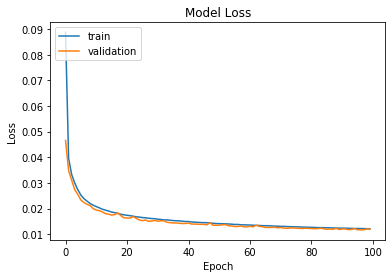

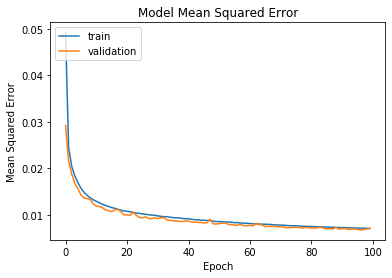

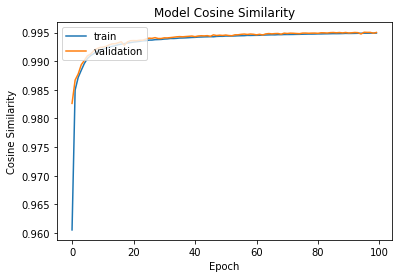

10000/10000 [==============================] - 7s 725us/sample - loss: 0.0117 - MeanSquaredError: 0.0067 - cosine_similarity: 0.9950
Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 156s 4ms/sample - loss: 0.1286 - MeanSquaredError: 0.0735 - cosine_similarity: 0.9449 - val_loss: 0.0657 - val_MeanSquaredError: 0.0430 - val_cosine_similarity: 0.9773
Epoch 2/100
40000/40000 [==============================] - 155s 4ms/sample - loss: 0.0579 - MeanSquaredError: 0.0371 - cosine_similarity: 0.9792 - val_loss: 0.0514 - val_MeanSquaredError: 0.0321 - val_cosine_similarity: 0.9806
Epoch 3/100
40000/40000 [==============================] - 154s 4ms/sample - loss: 0.0471 - MeanSquaredError: 0.0297 - cosine_similarity: 0.9826 - val_loss: 0.0430 - val_MeanSquaredError: 0.0272 - val_cosine_similarity: 0.9842
Epoch 4/100
40000/40000 [==============================] - 155s 4ms/sample - loss: 0.0406 - MeanSquaredError: 0.0255 - cosine_similarity

40000/40000 [==============================] - 41s 1ms/sample - loss: 0.0132 - MeanSquaredError: 0.0078 - cosine_similarity: 0.9946 - val_loss: 0.0128 - val_MeanSquaredError: 0.0076 - val_cosine_similarity: 0.9948
Epoch 72/100
40000/40000 [==============================] - 41s 1ms/sample - loss: 0.0132 - MeanSquaredError: 0.0077 - cosine_similarity: 0.9946 - val_loss: 0.0126 - val_MeanSquaredError: 0.0075 - val_cosine_similarity: 0.9948
Epoch 73/100
40000/40000 [==============================] - 41s 1ms/sample - loss: 0.0131 - MeanSquaredError: 0.0077 - cosine_similarity: 0.9946 - val_loss: 0.0126 - val_MeanSquaredError: 0.0075 - val_cosine_similarity: 0.9949
Epoch 74/100
40000/40000 [==============================] - 41s 1ms/sample - loss: 0.0131 - MeanSquaredError: 0.0077 - cosine_similarity: 0.9946 - val_loss: 0.0126 - val_MeanSquaredError: 0.0074 - val_cosine_similarity: 0.9948
Epoch 75/100
40000/40000 [==============================] - 41s 1ms/sample - loss: 0.0131 - MeanSquaredEr

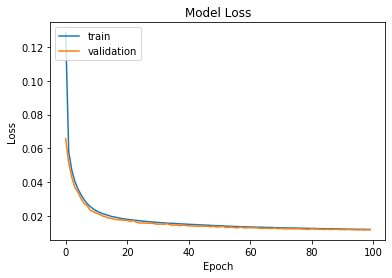

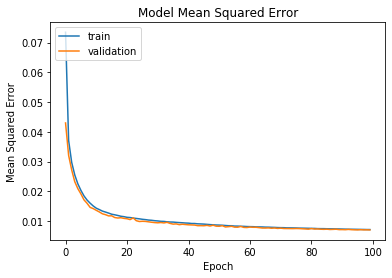

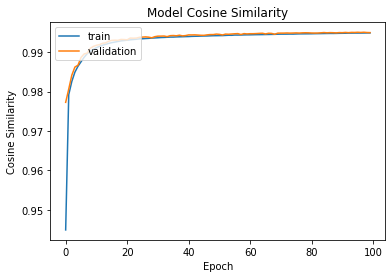

10000/10000 [==============================] - 13s 1ms/sample - loss: 0.0120 - MeanSquaredError: 0.0070 - cosine_similarity: 0.9951
Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 161s 4ms/sample - loss: 0.0695 - MeanSquaredError: 0.0439 - cosine_similarity: 0.9745 - val_loss: 0.0443 - val_MeanSquaredError: 0.0277 - val_cosine_similarity: 0.9835
Epoch 2/100
40000/40000 [==============================] - 161s 4ms/sample - loss: 0.0393 - MeanSquaredError: 0.0242 - cosine_similarity: 0.9848 - val_loss: 0.0361 - val_MeanSquaredError: 0.0226 - val_cosine_similarity: 0.9864
Epoch 3/100
40000/40000 [==============================] - 162s 4ms/sample - loss: 0.0329 - MeanSquaredError: 0.0199 - cosine_similarity: 0.9870 - val_loss: 0.0303 - val_MeanSquaredError: 0.0182 - val_cosine_similarity: 0.9879
Epoch 4/100
40000/40000 [==============================] - 161s 4ms/sample - loss: 0.0296 - MeanSquaredError: 0.0178 - cosine_similarity:

40000/40000 [==============================] - 162s 4ms/sample - loss: 0.0131 - MeanSquaredError: 0.0076 - cosine_similarity: 0.9945 - val_loss: 0.0126 - val_MeanSquaredError: 0.0073 - val_cosine_similarity: 0.9947
Epoch 72/100
40000/40000 [==============================] - 162s 4ms/sample - loss: 0.0130 - MeanSquaredError: 0.0076 - cosine_similarity: 0.9946 - val_loss: 0.0126 - val_MeanSquaredError: 0.0073 - val_cosine_similarity: 0.9947
Epoch 73/100
40000/40000 [==============================] - 162s 4ms/sample - loss: 0.0129 - MeanSquaredError: 0.0075 - cosine_similarity: 0.9946 - val_loss: 0.0130 - val_MeanSquaredError: 0.0075 - val_cosine_similarity: 0.9945
Epoch 74/100
40000/40000 [==============================] - 162s 4ms/sample - loss: 0.0129 - MeanSquaredError: 0.0075 - cosine_similarity: 0.9946 - val_loss: 0.0127 - val_MeanSquaredError: 0.0074 - val_cosine_similarity: 0.9947
Epoch 75/100
40000/40000 [==============================] - 162s 4ms/sample - loss: 0.0129 - MeanSqua

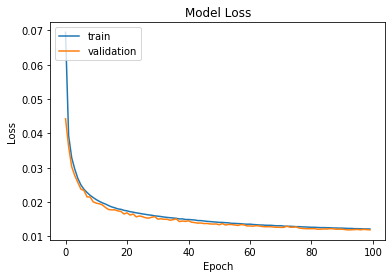

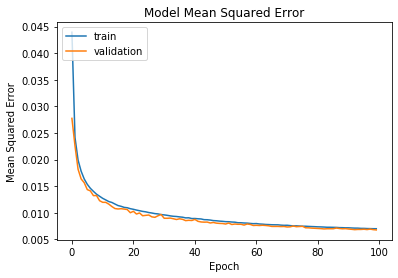

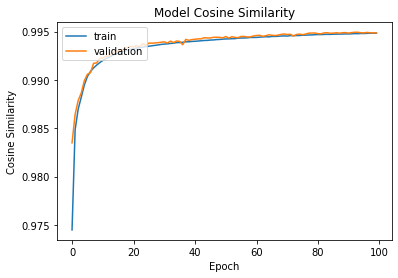

10000/10000 [==============================] - 13s 1ms/sample - loss: 0.0119 - MeanSquaredError: 0.0068 - cosine_similarity: 0.9949
Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 162s 4ms/sample - loss: 0.0717 - MeanSquaredError: 0.0437 - cosine_similarity: 0.9720 - val_loss: 0.0411 - val_MeanSquaredError: 0.0262 - val_cosine_similarity: 0.9851
Epoch 2/100
40000/40000 [==============================] - 161s 4ms/sample - loss: 0.0375 - MeanSquaredError: 0.0234 - cosine_similarity: 0.9859 - val_loss: 0.0333 - val_MeanSquaredError: 0.0204 - val_cosine_similarity: 0.9872
Epoch 3/100
40000/40000 [==============================] - 161s 4ms/sample - loss: 0.0322 - MeanSquaredError: 0.0199 - cosine_similarity: 0.9877 - val_loss: 0.0293 - val_MeanSquaredError: 0.0181 - val_cosine_similarity: 0.9888
Epoch 4/100
40000/40000 [==============================] - 161s 4ms/sample - loss: 0.0289 - MeanSquaredError: 0.0180 - cosine_similarity:

Epoch 71/100
40000/40000 [==============================] - 161s 4ms/sample - loss: 0.0132 - MeanSquaredError: 0.0077 - cosine_similarity: 0.9945 - val_loss: 0.0128 - val_MeanSquaredError: 0.0077 - val_cosine_similarity: 0.9949
Epoch 72/100
40000/40000 [==============================] - 161s 4ms/sample - loss: 0.0131 - MeanSquaredError: 0.0077 - cosine_similarity: 0.9946 - val_loss: 0.0123 - val_MeanSquaredError: 0.0073 - val_cosine_similarity: 0.9950
Epoch 73/100
40000/40000 [==============================] - 131s 3ms/sample - loss: 0.0132 - MeanSquaredError: 0.0077 - cosine_similarity: 0.9945 - val_loss: 0.0126 - val_MeanSquaredError: 0.0074 - val_cosine_similarity: 0.9948
Epoch 74/100
40000/40000 [==============================] - 43s 1ms/sample - loss: 0.0131 - MeanSquaredError: 0.0077 - cosine_similarity: 0.9945 - val_loss: 0.0122 - val_MeanSquaredError: 0.0073 - val_cosine_similarity: 0.9950
Epoch 75/100
40000/40000 [==============================] - 76s 2ms/sample - loss: 0.0130

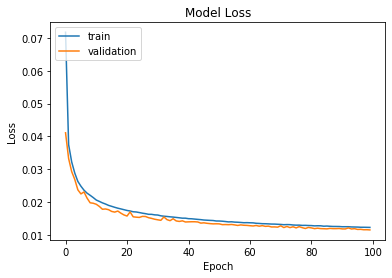

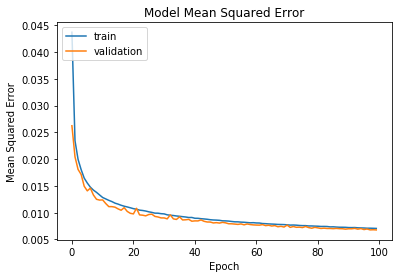

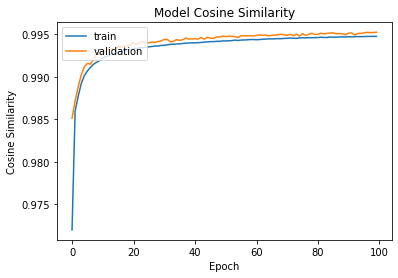

10000/10000 [==============================] - 13s 1ms/sample - loss: 0.0115 - MeanSquaredError: 0.0068 - cosine_similarity: 0.9953
Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 162s 4ms/sample - loss: 0.1073 - MeanSquaredError: 0.0661 - cosine_similarity: 0.9588 - val_loss: 0.0630 - val_MeanSquaredError: 0.0424 - val_cosine_similarity: 0.9794
Epoch 2/100
40000/40000 [==============================] - 161s 4ms/sample - loss: 0.0557 - MeanSquaredError: 0.0376 - cosine_similarity: 0.9818 - val_loss: 0.0489 - val_MeanSquaredError: 0.0321 - val_cosine_similarity: 0.9832
Epoch 3/100
40000/40000 [==============================] - 161s 4ms/sample - loss: 0.0454 - MeanSquaredError: 0.0299 - cosine_similarity: 0.9845 - val_loss: 0.0408 - val_MeanSquaredError: 0.0260 - val_cosine_similarity: 0.9852
Epoch 4/100
40000/40000 [==============================] - 161s 4ms/sample - loss: 0.0390 - MeanSquaredError: 0.0250 - cosine_similarity:

Epoch 71/100
40000/40000 [==============================] - 161s 4ms/sample - loss: 0.0133 - MeanSquaredError: 0.0079 - cosine_similarity: 0.9946 - val_loss: 0.0129 - val_MeanSquaredError: 0.0075 - val_cosine_similarity: 0.9945
Epoch 72/100
40000/40000 [==============================] - 161s 4ms/sample - loss: 0.0133 - MeanSquaredError: 0.0079 - cosine_similarity: 0.9946 - val_loss: 0.0131 - val_MeanSquaredError: 0.0076 - val_cosine_similarity: 0.9946
Epoch 73/100
40000/40000 [==============================] - 161s 4ms/sample - loss: 0.0132 - MeanSquaredError: 0.0079 - cosine_similarity: 0.9947 - val_loss: 0.0130 - val_MeanSquaredError: 0.0076 - val_cosine_similarity: 0.9946
Epoch 74/100
40000/40000 [==============================] - 161s 4ms/sample - loss: 0.0132 - MeanSquaredError: 0.0079 - cosine_similarity: 0.9947 - val_loss: 0.0126 - val_MeanSquaredError: 0.0073 - val_cosine_similarity: 0.9947
Epoch 75/100
40000/40000 [==============================] - 161s 4ms/sample - loss: 0.01

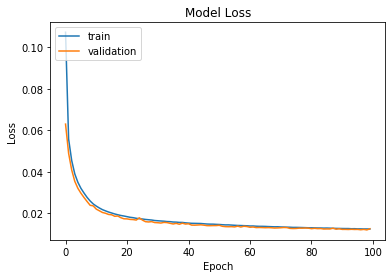

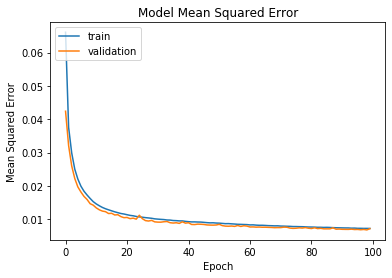

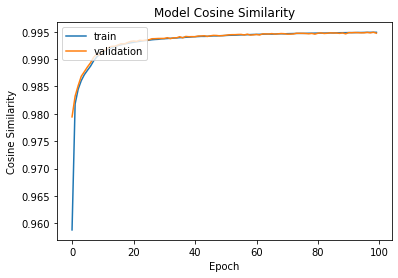

10000/10000 [==============================] - 13s 1ms/sample - loss: 0.0119 - MeanSquaredError: 0.0068 - cosine_similarity: 0.9949
The Mean Train MSE for the Cross-Validation =  0.0067925299517810345  - with Standard Deviation =  8.746359832238603e-05
The Mean Validation MSE for the Cross-Validation =  0.006822464242577553  - with Standard Deviation =  9.957701312792661e-05
The Mean Train Cosine Similarity for the Cross-Validation =  0.9950924396514893  - with Standard Deviation =  4.733562673628476e-05
The Mean Validation Cosine Similarity for the Cross-Validation =  0.9950321793556214  - with Standard Deviation =  0.0001233173481717828


In [9]:
arq_path = 'D:\Luiza\OneDrive\Documentos\Doutorado\MeusProjetos\\autoencoder\cifar10'
train_evaluate(n_epoch=100, b_size=32, arq_path = arq_path)

D:\Luiza\OneDrive\Documentos\Doutorado\MeusProjetos\autoencoder\cifar10\cifar-10-batches-py\data_batch_1
D:\Luiza\OneDrive\Documentos\Doutorado\MeusProjetos\autoencoder\cifar10\cifar-10-batches-py\data_batch_2
D:\Luiza\OneDrive\Documentos\Doutorado\MeusProjetos\autoencoder\cifar10\cifar-10-batches-py\data_batch_3
D:\Luiza\OneDrive\Documentos\Doutorado\MeusProjetos\autoencoder\cifar10\cifar-10-batches-py\data_batch_4
D:\Luiza\OneDrive\Documentos\Doutorado\MeusProjetos\autoencoder\cifar10\cifar-10-batches-py\data_batch_5
D:\Luiza\OneDrive\Documentos\Doutorado\MeusProjetos\autoencoder\cifar10\cifar-10-batches-py\/test_batch
D:\Luiza\OneDrive\Documentos\Doutorado\MeusProjetos\autoencoder\cifar10\cifar-10-batches-py\batches.meta


<Figure size 432x288 with 0 Axes>

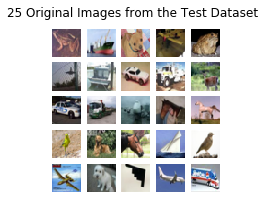

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

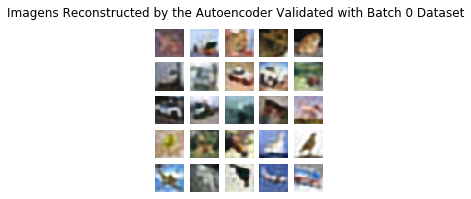

10000/10000 [==============================] - 3s 274us/sample - loss: 0.0118 - MeanSquaredError: 0.0067 - cosine_similarity: 0.9950


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

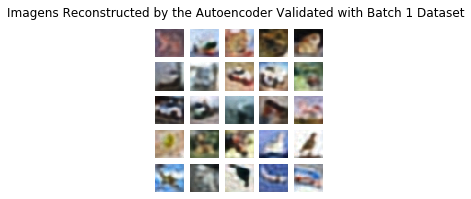

10000/10000 [==============================] - 2s 233us/sample - loss: 0.0121 - MeanSquaredError: 0.0070 - cosine_similarity: 0.9949


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

<Figure size 432x288 with 0 Axes>

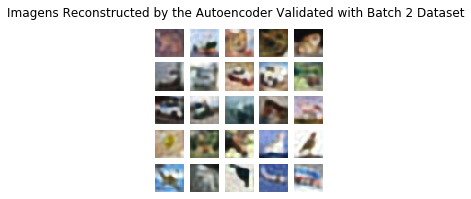

10000/10000 [==============================] - 2s 235us/sample - loss: 0.0119 - MeanSquaredError: 0.0068 - cosine_similarity: 0.9949


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

<Figure size 432x288 with 0 Axes>

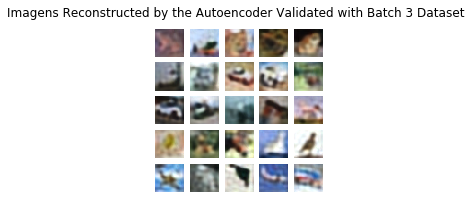

10000/10000 [==============================] - 2s 236us/sample - loss: 0.0119 - MeanSquaredError: 0.0068 - cosine_similarity: 0.9949


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

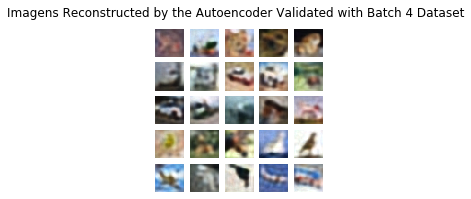

10000/10000 [==============================] - 2s 244us/sample - loss: 0.0119 - MeanSquaredError: 0.0068 - cosine_similarity: 0.9949
The Mean Test MSE for the Cross-Validation =  0.006812336668372154  - with Standard Deviation =  8.877995577015185e-05
The Mean Test Cosine Similarity for the Cross-Validation =  0.9949137926101684  - with Standard Deviation =  3.2560258057923236e-05


In [10]:
arq_path = 'D:\Luiza\OneDrive\Documentos\Doutorado\MeusProjetos\\autoencoder\cifar10'
batch = load_data (arq_path)
    
i_train = np.arange(5)
    
data_train, data_val, data_test, label_train, label_val, label_test = datasets_crossValitation (batch, i_train, i_crossVal=0)

i = np.random.choice(range(len(data_test)),25)

t=0
plt.figure()
fig, axes1 = plt.subplots(5,5,figsize=(3,3))
i_aux=np.zeros((5,5))
for j in range(5):
    for k in range(5):
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(data_test[i[t]])
        t+=1
fig.suptitle('25 Original Images from the Test Dataset')
plt.show()  
    
test_mse = np.zeros((5))
test_consineSimilarity = np.zeros((5))

for i_crossVal in range(5):
    
   
    model = tf.keras.models.load_model(arq_path + '\Encoder_model_'+str(i_crossVal)+'.h5', custom_objects={'my_loss_fn': my_loss_fn})
    
    
    y_hat=model.predict( data_test[i] )

    t=0
    plt.figure()
    fig, axes1 = plt.subplots(5,5,figsize=(3,3))
    for j in range(5):
        for k in range(5):
            axes1[j][k].set_axis_off()
            axes1[j][k].imshow(y_hat[t])
            t+=1
    fig.suptitle('Imagens Reconstructed by the Autoencoder Validated with Batch ' + str(i_crossVal) + ' Dataset')
    plt.show()
    _, test_mse[i_crossVal], test_consineSimilarity[i_crossVal] = model.evaluate(x=data_test, y=data_test, batch_size=128)
            
test_mse_mean = np.mean(test_mse)
test_mse_std = np.std(test_mse)

test_consineSimilarity_mean = np.mean(test_consineSimilarity)
test_consineSimilarity_std = np.std(test_consineSimilarity)

print('The Mean Test MSE for the Cross-Validation = ', test_mse_mean, ' - with Standard Deviation = ', test_mse_std)
print('The Mean Test Cosine Similarity for the Cross-Validation = ', test_consineSimilarity_mean, ' - with Standard Deviation = ', test_consineSimilarity_std)
    
       
